# Anaylsis Bike Sharing Data

In [350]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline
from sqlalchemy import create_engine
import requests
import time

import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
import geoplot

# Analysis

In [122]:
df = pd.read_csv('../../data/cleaned.csv', parse_dates=['timestamp','end_timestamp', 'duration'])

In [265]:
df = df[(df['mode'] != 'trip') | (df.distance > 300)].copy(deep=True)

In [172]:
df.duration = df.end_timestamp - df.timestamp

In [345]:
# day of the year
df['yday'] = df.timestamp.apply(lambda x: x.timetuple().tm_yday)

# hour of the day
df['dhour'] = df.timestamp.apply(lambda x: x.time().hour)

# "hour of the year"
df['yhour'] = df.dhour + (df.yday * 24)

# day of week
df['dweek'] = df.timestamp.apply(lambda x: x.weekday())

# "hour of the week"
df['whour'] = df.dhour + (df.dweek * 24)

# calendarweek
df['calweek'] = df.timestamp.apply(lambda x: x.isocalendar()[1])

In [346]:
nomo = df[df.providerId != 2]

In [347]:
# delete all trips starting at 4am
nomo = nomo[nomo.dhour != 4]

In [348]:
trips = nomo[nomo['mode'] == 'trip']

In [21]:
# df.loc[:,'hourly_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [351]:
df.describe()

,id,id.1,bikeId,providerId,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,distance,calc_time,duration,speed,yday,dhour,yhour,dweek,whour,calweek
count,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,...,510231.000000,510231.000000,3475419,510231.000000,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06,3.475419e+06
mean,2.431806e+06,2.431806e+06,6.092921e+08,1.673670e+00,5.250982e+01,1.338656e+01,6.092918e+08,6.092921e+08,5.250982e+01,1.338669e+01,...,2594.420315,766.692166,0 days 04:17:51.492495,5.853632,1.376997e+02,1.196783e+01,3.316760e+03,2.977556e+00,8.342917e+01,2.024602e+01
std,1.466461e+06,1.466461e+06,3.527640e+08,6.084931e-01,2.151807e-02,4.759582e-02,3.527641e+08,3.527640e+08,3.104905e-02,1.371807e-01,...,2049.594306,565.149423,0 days 10:59:22.710403,5.820609,2.744640e+01,6.756400e+00,6.587374e+02,2.001129e+00,4.846316e+01,3.920699e+00
min,1.000000e+00,1.000000e+00,1.300100e+04,0.000000e+00,5.233902e+01,1.301072e+01,1.300100e+04,1.300100e+04,2.248054e+01,-1.344200e+02,...,300.100000,50.700000,0 days 00:00:06.225870,0.012928,9.100000e+01,0.000000e+00,2.197000e+03,0.000000e+00,0.000000e+00,1.400000e+01
25%,1.103920e+06,1.103920e+06,1.869630e+05,1.000000e+00,5.249339e+01,1.334900e+01,1.869630e+05,1.869630e+05,5.249333e+01,1.334946e+01,...,1056.500000,343.700000,0 days 00:28:00.543078,1.162022,1.130000e+02,6.000000e+00,2.734000e+03,1.000000e+00,4.100000e+01,1.700000e+01
50%,2.414034e+06,2.414034e+06,8.100236e+08,2.000000e+00,5.250900e+01,1.338859e+01,8.100236e+08,8.100236e+08,5.250904e+01,1.338910e+01,...,2002.200000,612.300000,0 days 02:39:59.914523,4.769549,1.380000e+02,1.200000e+01,3.324000e+03,3.000000e+00,8.400000e+01,2.000000e+01
75%,3.709731e+06,3.709731e+06,8.160356e+08,2.000000e+00,5.252605e+01,1.342517e+01,8.160356e+08,8.160356e+08,5.252613e+01,1.342521e+01,...,3601.250000,1051.600000,0 days 03:47:59.695242,8.364029,1.620000e+02,1.800000e+01,3.888000e+03,5.000000e+00,1.250000e+02,2.400000e+01
max,5.000216e+06,5.000216e+06,8.160550e+08,2.000000e+00,5.268865e+01,1.378699e+01,8.160550e+08,8.160550e+08,5.830499e+01,1.631155e+01,...,34504.700000,9376.200000,93 days 21:35:59.111435,29.999916,1.920000e+02,2.300000e+01,4.622000e+03,6.000000e+00,1.670000e+02,2.800000e+01


In [71]:
df['mode'].value_counts()

trip    510231
Name: mode, dtype: int64

## Distance

In [90]:
## sum of kilometers driven each day

In [294]:
nomo.groupby('yday').sum().distance.describe()

count    1.020000e+02
mean     8.181863e+06
std      3.060360e+06
min      1.554133e+06
25%      6.624518e+06
50%      8.730289e+06
75%      1.034454e+07
max      1.409361e+07
Name: distance, dtype: float64

In [295]:
## average distance

In [296]:
nomo.distance.describe()

count    285505.000000
mean       2923.066337
std        2068.878080
min         300.100000
25%        1392.400000
50%        2416.400000
75%        3990.900000
max       34504.700000
Name: distance, dtype: float64

In [297]:
# average distance per provider

In [298]:
df.groupby('providerId').distance.describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,96060.0,3181.509189,2302.334391,300.2,1491.5,2651.25,4328.200,34504.7
1,192576.0,2772.546322,1930.933922,300.1,1327.9,2284.90,3793.325,18159.2
2,221595.0,2185.121588,1946.801769,300.1,740.5,1562.30,2993.500,13909.0


## Duration

In [305]:
trips.duration.describe()

count                    285505
mean     0 days 01:37:44.060788
std      0 days 03:57:21.167035
min      0 days 00:03:08.838554
25%      0 days 00:15:59.737327
50%      0 days 00:23:59.672760
75%      0 days 00:40:00.278078
max      0 days 23:59:59.988111
Name: duration, dtype: object

In [306]:
trips.groupby('providerId').duration.describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,95594,0 days 03:24:06.610921,0 days 05:54:10.698723,0 days 00:03:08.838554,0 days 00:16:00.942989,0 days 00:31:59.754681,0 days 02:56:00.061008,0 days 23:59:59.988111
1,189911,0 days 00:44:11.326942,0 days 01:53:57.996358,0 days 00:03:32.949500,0 days 00:15:59.375762,0 days 00:20:00.649095,0 days 00:32:00.097121,0 days 23:59:59.786224


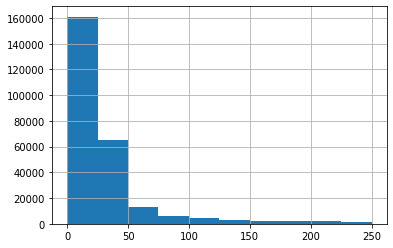

In [307]:
# histogram of minutes spent on trip
trips.duration.apply(lambda x: x.seconds / 60).hist(range=(0,250))

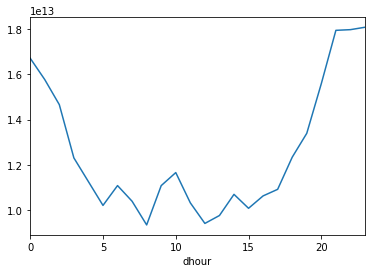

In [308]:
trips[trips.providerId == 0].groupby('dhour').duration.describe()['mean'].plot()

mobikes are used longer during night (some kind of error?)

## daily counts of trips

In [309]:
# daily average trips counts
nomo.groupby('yday').count().id.describe()

count      102.000000
mean      7082.274510
std       2495.347719
min       1673.000000
25%       5977.500000
50%       7616.500000
75%       8588.500000
max      13637.000000
Name: id, dtype: float64

In [310]:
# daily trips by provider
nomo.groupby(['yday', 'providerId']).count().id.groupby('providerId').mean()

providerId
0    2678.288660
1    5139.977778
Name: id, dtype: float64

## count of trips each hour

In [311]:
counts = trips[['bikeId', 'yhour']].groupby(['yhour']).count()

In [314]:
nb = trips[trips.providerId == 0][['bikeId', 'yhour']].groupby(['yhour']).count()

lb = trips[trips.providerId == 1][['bikeId', 'yhour']].groupby(['yhour']).count()

# mb = trips[trips.providerId == 2][['bikeId', 'yhour']].groupby(['yhour']).count()

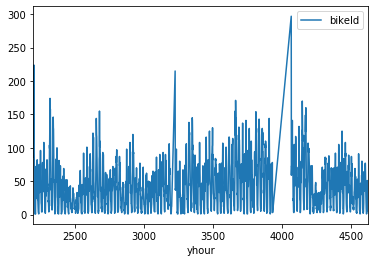

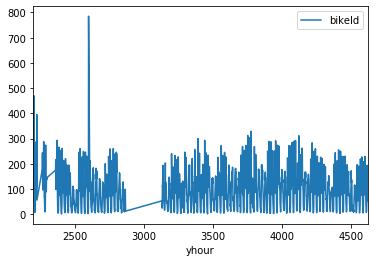

In [315]:
nb.plot()
lb.plot()
# mb.plot()

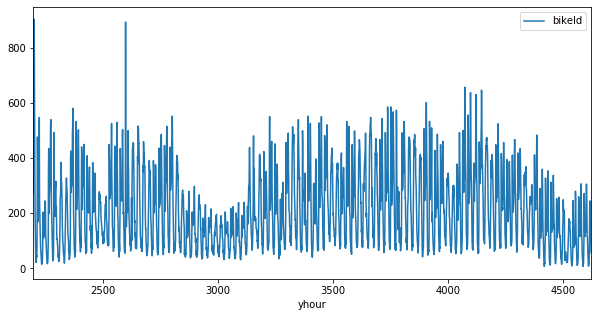

In [65]:
counts.plot(figsize=(10,5))

## How many unique bike IDs are there (per provider)?

In [124]:
# how many bikes are available / on a trip for each hour?
def get_unique_ids_per_day(df):
    daily_unique = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    
    # get all desired times
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=24)
    
    daily_unique['time'] = times
    daily_unique['total'] = daily_unique.time.apply(lambda x: df[
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['nextbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['lidlbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['mobike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    
    return daily_unique
    

In [125]:
def get_unique_ids(df):
    unique_bikes = pd.DataFrame()
    unique_bikes = unique_bikes.append([([df.bikeId.unique().shape[0], df[(df.providerId == 0)].bikeId.unique().shape[0], 
             df[(df.providerId == 1)].bikeId.unique().shape[0],
             df[(df.providerId == 2)].bikeId.unique().shape[0]])])
    unique_bikes.columns = [['total', 'nextbike', 'lidlbike', 'mobike']]
    return unique_bikes

In [259]:
daily_uniques = get_unique_ids_per_day(nomo)

In [260]:
daily_uniques.describe()

,total,nextbike,lidlbike,mobike
count,102.000000,102.000000,102.000000,102.0
mean,3385.813725,1051.509804,2334.303922,0.0
std,977.997800,185.369727,922.730899,0.0
min,262.000000,86.000000,95.000000,0.0
25%,3567.500000,975.250000,2577.750000,0.0
50%,3778.000000,1061.500000,2723.500000,0.0
75%,3954.250000,1175.750000,2792.250000,0.0
max,4085.000000,1337.000000,2940.000000,0.0


In [261]:
available_nextbike = daily_uniques.describe().nextbike.loc['50%']
available_lidlbike = daily_uniques.describe().lidlbike.loc['50%']
available_total = daily_uniques.describe().total.loc['50%']

In [119]:
uniques = get_unique_ids(df)
uniques

,total,nextbike,lidlbike,mobike
0,15021,2364,3540,9117


#### How much time is a bike used? 

In [87]:
# average trips per bike
trips.groupby(['bikeId', 'providerId']).count().id.groupby('providerId').describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,2365.0,42.797040,16.472283,1.0,33.0,43.0,53.0,191.0
1,3551.0,59.564066,26.760414,1.0,42.0,62.0,79.0,161.0
2,9186.0,37.920422,69.884386,1.0,17.0,30.0,45.0,1823.0


## how high is the utilization rate? (available bikes / all bikes)

In [129]:
## more precise, than general average of available bikes
#
# all accessibe bikes each day
# accessible = df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count()

# merge df on accessible bikes per day
# in_use = in_use['id'].reset_index().set_index(['yday', 'providerId', 'dhour']).join(accessible['id.1'].reset_index().set_index(['yday', 'providerId']))
# in_use.rename(columns={"id": "in_use", "id.1": "accessible"}, inplace=True)

In [146]:
# how many bikes are available / on a trip for each hour?
def count_bikes_in_mode(df, mode):
    bikes_accessible = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=1)
    
    bikes_accessible['time'] = times
    bikes_accessible['total'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['nextbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 0) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['lidlbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 1) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
   # bikes_accessible['mobike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
    #           (df.providerId == 2)&
     #          (df.timestamp <= x) & 
      #         (df.end_timestamp > x)].bikeId.unique().shape[0])
    
    # day of the year
    bikes_accessible['yday'] = bikes_accessible.time.apply(lambda x: x.timetuple().tm_yday)

    # hour of the day
    bikes_accessible['dhour'] = bikes_accessible.time.apply(lambda x: x.time().hour)

    # "hour of the year"
    bikes_accessible['yhour'] = bikes_accessible.dhour + (bikes_accessible.yday * 24)

    # day of week
    bikes_accessible['dweek'] = bikes_accessible.time.apply(lambda x: x.weekday())
    return bikes_accessible

In [221]:
in_use = count_bikes_in_mode(nomo[(nomo.timestamp > datetime.datetime(2019,6,1)) & (nomo.timestamp < datetime.datetime(2019,7,1))].sort_values('timestamp'), 'trip')

In [222]:
in_use['nextbike'] = in_use.nextbike / available_nextbike
in_use['lidlbike'] = in_use.lidlbike / available_lidlbike
in_use['total'] = in_use.total / available_total

In [223]:
# in_use.groupby('dhour').mean()

In [230]:
in_use.describe()

,total,nextbike,lidlbike,yday,dhour,yhour,dweek
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.032488,0.141295,0.026134,166.500000,11.500000,4007.500000,3.166667
std,0.015736,0.084439,0.016040,8.661458,6.926999,207.990384,2.035840
min,0.000881,0.000000,0.000000,152.000000,0.000000,3648.000000,0.000000
25%,0.021888,0.081488,0.011382,159.000000,5.750000,3827.750000,1.000000
50%,0.033713,0.164861,0.024601,166.500000,11.500000,4007.500000,3.000000
75%,0.043188,0.205370,0.037452,174.000000,17.250000,4187.250000,5.000000
max,0.072126,0.300518,0.073435,181.000000,23.000000,4367.000000,6.000000


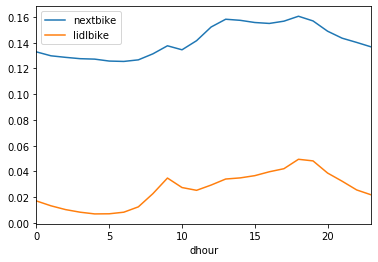

In [224]:
in_use.groupby('dhour').mean()[['nextbike', 'lidlbike']].plot()

Usage rate varies between 0 and 16 %.

#### how many bikes bikes are accessible / in use each day?

In [269]:
# on average accessible bikes per day
df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count().groupby('providerId').median()

,id,id.1,bikeId,timestamp,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,response,geometry,distance,calc_time,waypoints,duration,speed,dhour,yhour,dweek
providerId,,,,,,,,,,,,,,,,,,,,,
0,953,953,953,953,953,953,953,953,953,953,...,360,360,360,360,360,953,360,953,953,953
1,2326,2326,2326,2326,2326,2326,2326,2326,2326,2326,...,497,497,497,497,497,2326,497,2326,2326,2326
2,4373,4373,4373,4373,4373,4373,4373,4373,4373,4373,...,161,161,161,161,161,4373,161,4373,4373,4373


In [270]:
# on overage used bikes per day
trips.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count().groupby('providerId').median().id

providerId
0     599
1    1163
Name: id, dtype: int64

In [271]:
# on overage used bikes per hour
trips.groupby(['providerId', 'yhour']).count().groupby('providerId').median().id

providerId
0    37
1    87
Name: id, dtype: int64

In [272]:
# percentage of bikes used daily
trips.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby('yday').count().median().id / available_total


0.45023822128110114

## How many rides per bike per day?

In [316]:
trips.groupby(['yday', 'bikeId', 'providerId']).count().groupby('providerId').median().id

providerId
0    1
1    2
Name: id, dtype: int64

Median of 1-2 rides per bike per day.

In [317]:
trips.groupby(['yday', 'bikeId']).count().id.describe()

count    158008.000000
mean          1.806902
std           1.100434
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          32.000000
Name: id, dtype: float64

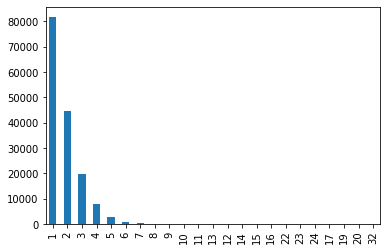

In [318]:
trips.groupby(['yday', 'bikeId']).count().id.value_counts().plot(kind='bar')

#### Bike Availability: 
- Where are bikes available (per Planungsraum)? On average? On average weekdays / times?
- Distance between available bikes

#### how long is the life span of a bike? (first appearence and last appearence)
- is there periodical appearences?

In [259]:
# get data for lifespan

def lifespan (df):
    # each line one trip with start-loc and end-loc
    # for each bike ID
    start_timestamp = df.sort_values(by=['bikeId', 'timestamp']).drop_duplicates('bikeId', keep='first')
    last_timestamp = df.sort_values(by=['bikeId', 'timestamp'], ascending = False).drop_duplicates('bikeId', keep='first')
    start_timestamp.set_index('bikeId', inplace=True)
    last_timestamp.set_index('bikeId', inplace=True)
    return start_timestamp.join(last_timestamp[['timestamp']], rsuffix='_last')

In [261]:
lifespan = lifespan(df)

In [268]:
(lifespan.timestamp_last - lifespan.timestamp).median()

Timedelta('88 days 06:09:59.964870')

#### speed of bikes

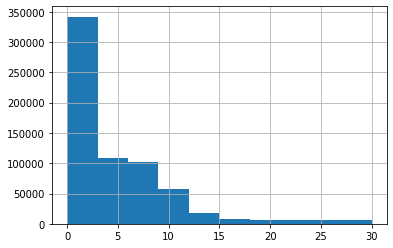

In [271]:
df['speed'].hist()

In [272]:
df['speed'].describe()

count    661064.000000
mean          4.711225
std           5.547541
min           0.004344
25%           0.526149
50%           2.731577
75%           7.240797
max          29.999916
Name: speed, dtype: float64

## How many bikes are in use at what point in time (weekday)?

In [321]:
# hour of day

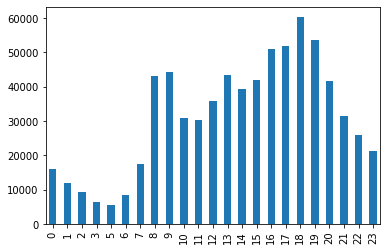

In [320]:
nomo.dhour.value_counts().sort_index().plot(kind='bar')

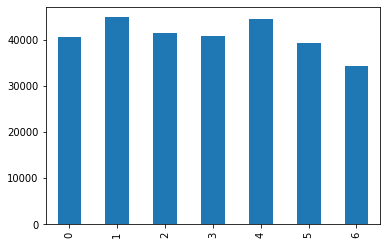

In [326]:
trips.dweek.value_counts().sort_index().plot(kind='bar')

In [359]:
pd.DataFrame(trips.whour.value_counts().sort_index()).to_csv('../../data/week_usage.csv')

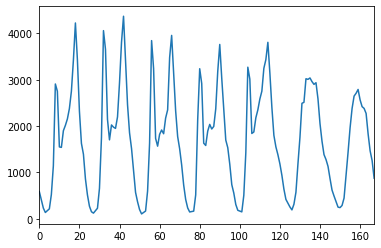

In [353]:
trips.whour.value_counts().sort_index().plot()

In [ ]:
# plot week of year

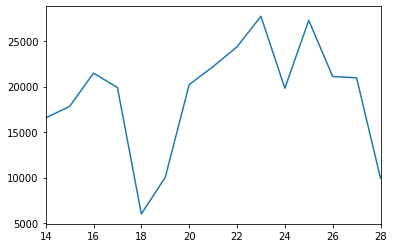

In [349]:
trips.calweek.value_counts().sort_index().plot()

In [298]:
df.loc[:,'hourly_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [299]:
df[df['mode']=='trip'].hourly_starttime.describe()

count                 2122449
unique                   2405
top       2019-03-28 09:00:00
freq                     2262
first     2019-03-27 18:00:00
last      2019-07-09 19:00:00
Name: hourly_starttime, dtype: object

#### How many rides are there per day?

#### How long is the average ride (time and length)? How fast?

## Geoanalysis 

In [330]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [331]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
endpoints = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [332]:
gdf[['geometry']].head(1000).to_file('../../data/small_startpoints.geojson', Driver='GeoJSON')

In [333]:
gdf_vbb = gpd.read_file('../../data/haltestellen-berlin.geojson')

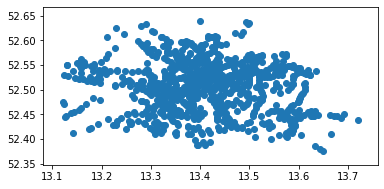

In [334]:
gdf_vbb.plot()

In [335]:
gdf_plr = gpd.read_file('lor_planungsraeume.geojson')

In [336]:
pointInPolys = sjoin(gdf_data.head(), gdf, how='left')

NameError: name 'gdf_data' is not defined

In [ ]:
gdf_data.intersects(gdf.unary_union)

In [ ]:
gpd.overlay(gdf, gdf_data)

#### Where are most rides? (Bezirk, ...) Heatmap

In [ ]:
ax = geoplot.kdeplot(gdf,
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(gdf_plr, ax=ax)

In [ ]:
# cross with Planungsräume

gdf.rename(index=str, columns={"spatial_name": "cell_id"}, inplace=True)
gdf[['cell_id', 'geometry']].to_file('planungsraeume.json', driver='GeoJSON')
df = pd.DataFrame(gdf)[['cell_id', 'geometry']]
gdf.set_index('cell_id', inplace=True)
gdf['geometry'].to_file('test2.json', driver='GeoJSON', index='False')
f= open("test.json","w")
f.write(gdf['geometry'].to_json())
f.close()    
test = gdf['geometry'].to_dict()
for key, values in test.items():
    print (key)
test = pd.read_json('test.json', orient='records')

#### What are highly frequented routes? (Are there good bike lanes? Should there be better bike lanes?)

#### Are there "hot spots" for pick up and drop off?

## pseudonomysed trip data

In [ ]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf = gdf.to_crs(epsg=25833)

In [ ]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
gdf_end = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf_end = gdf_end.to_crs(epsg=25833)

In [ ]:
berlin = geopandas.read_file('lor_planungsraeume.geojson')
berlin = berlin.to_crs(epsg=25833)

In [ ]:
# map of accessible bikes
base = berlin.plot(color='white', edgecolor='black', figsize=(20,20))
gdf[(gdf['mode']=='accessible') & (gdf.latitude > 52.3) & (gdf.longitude > 13.0)& (gdf.latitude < 53.7) & (gdf.longitude < 13.7)].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of startpoints
gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of endpoints
gdf_end[(gdf_end['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map both
start = gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20), color='red')
gdf_end[(gdf_end['mode']=='trip')].plot(ax=start, markersize=0.01, figsize=(20,20))

In [ ]:
# heatmap (?)
import geoplot
ax = geoplot.kdeplot(gdf.head(100),
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(boroughs, ax=base)

## Include further data

#### Intersect with subway stops

#### weather data

#### nextbike stations: with and without docking station: how many rides start from / end at a docking station